In this notebook, we will present how to merge datasets in scVI

In [2]:
import os
os.chdir("/home/ec2-user/scVI/")
os.getcwd()

'/home/ec2-user/scVI'

In [3]:
use_cuda = True

from scvi.dataset.dataset import GeneExpressionDataset
from scvi.dataset.pbmc import Dataset10X, PbmcDataset

from scvi.inference.posterior import *
from scvi.metrics.clustering import select_indices_evenly, clustering_scores, entropy_batch_mixing
from scipy import sparse
from scvi.models.vae import VAE
from scvi.inference import UnsupervisedTrainer

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
pbmc = PbmcDataset()

File data/gene_info_pbmc.csv already downloaded
File data/pbmc_metadata.pickle already downloaded
File data/10X/pbmc8k/filtered_gene_bc_matrices.tar.gz already downloaded
Preprocessing dataset
Finished preprocessing dataset
Downsampling from 33694 to 21425 genes
Downsampling from 8381 to 8381 cells
File data/10X/pbmc4k/filtered_gene_bc_matrices.tar.gz already downloaded
Preprocessing dataset
Finished preprocessing dataset
Downsampling from 33694 to 19773 genes
Downsampling from 4340 to 4340 cells
Keeping 19039 genes
Downsampling from 12721 to 11990 cells
Downsampling from 19039 to 19036 genes
Downsampling from 11990 to 11990 cells
Downsampling from 19036 to 3346 genes
Downsampling from 11990 to 11990 cells


In [8]:
pbmc.cell_types

array(['B cells', 'CD14+ Monocytes', 'CD4 T cells', 'CD8 T cells',
       'Dendritic Cells', 'FCGR3A+ Monocytes', 'Megakaryocytes',
       'NK cells', 'Other'], dtype=object)

In [7]:
cell_types = np.array(["cd4_t_helper", "regulatory_t", "naive_t", "memory_t", "cytotoxic_t", "naive_cytotoxic",
                       "b_cells", "cd4_t_helper", "cd34", "cd56_nk", "cd14_monocytes"])
datasets = []
for cell_type in cell_types:
    dataset = Dataset10X(cell_type, save_path='data/')
    dataset.cell_types = np.array([cell_type])
    dataset.gene_names = dataset.gene_symbols
    datasets += [dataset]

File data/10X/cd4_t_helper/filtered_gene_bc_matrices.tar.gz already downloaded
Preprocessing dataset
Finished preprocessing dataset
File data/10X/regulatory_t/filtered_gene_bc_matrices.tar.gz already downloaded
Preprocessing dataset
Finished preprocessing dataset
File data/10X/naive_t/filtered_gene_bc_matrices.tar.gz already downloaded
Preprocessing dataset
Finished preprocessing dataset
File data/10X/memory_t/filtered_gene_bc_matrices.tar.gz already downloaded
Preprocessing dataset
Finished preprocessing dataset
File data/10X/cytotoxic_t/filtered_gene_bc_matrices.tar.gz already downloaded
Preprocessing dataset
Finished preprocessing dataset
File data/10X/naive_cytotoxic/filtered_gene_bc_matrices.tar.gz already downloaded
Preprocessing dataset
Finished preprocessing dataset
File data/10X/b_cells/filtered_gene_bc_matrices.tar.gz already downloaded
Preprocessing dataset
Finished preprocessing dataset
File data/10X/cd4_t_helper/filtered_gene_bc_matrices.tar.gz already downloaded
Preproces

In [9]:
pure = GeneExpressionDataset.concat_datasets(*datasets, shared_batches=True)

Keeping 32738 genes


In [10]:
gene_dataset = GeneExpressionDataset.concat_datasets(pbmc, pure)

Keeping 3343 genes


In [11]:
gene_dataset.X.shape

(117858, 3343)

In [12]:
vae = VAE(gene_dataset.nb_genes, n_batch=gene_dataset.n_batches, n_labels=gene_dataset.n_labels,
          n_hidden=128, n_latent=10, n_layers=2, dispersion='gene')
trainer = UnsupervisedTrainer(vae, gene_dataset, train_size=1.0)
trainer.train(n_epochs=100)

training: 100%|██████████| 50/50 [09:38<00:00, 11.56s/it]


In [23]:
latent, batch_indices, labels = trainer.train_set.get_latent(sample=True)
latent, idx_t_sne = trainer.train_set.apply_t_sne(latent, 10000)

In [35]:
np.unique(batch_indices[:, 0])

array([0, 1, 2])

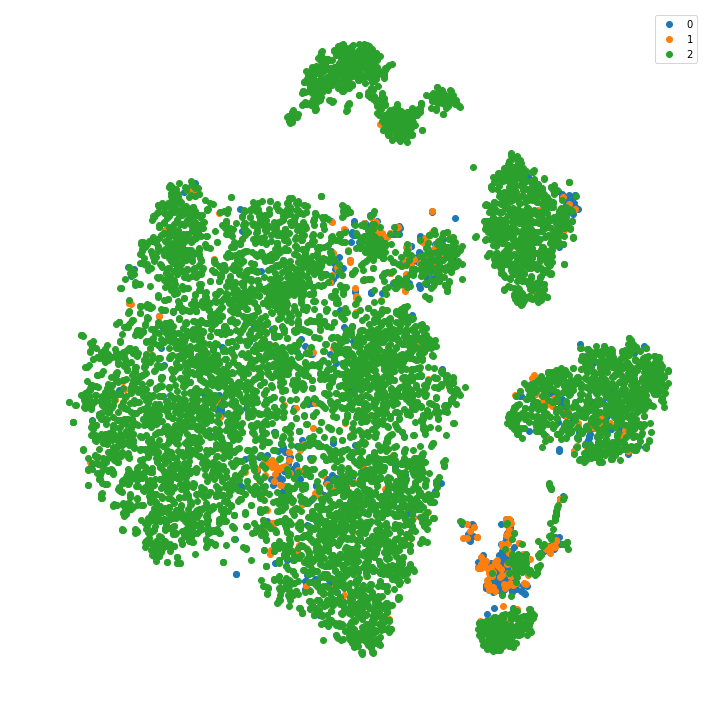

In [36]:
trainer.train_set.show_t_sne(latent=latent, 
                             batch_indices=batch_indices[idx_t_sne][:, 0], 
                             labels=labels[idx_t_sne], 
                             color_by='batches')

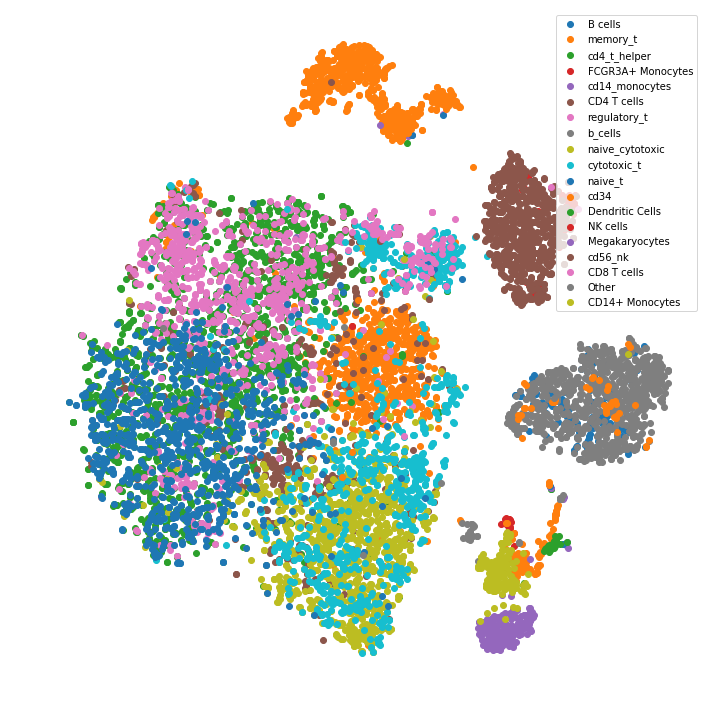

In [38]:
trainer.train_set.show_t_sne(latent=latent, 
                             batch_indices=batch_indices[idx_t_sne][:, 0], 
                             labels=labels[idx_t_sne], 
                             color_by='labels')